<a href="https://colab.research.google.com/github/Saoudyahya/mechanistic-interpretability-decoder-only/blob/main/final_mech_inte2r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import math
from typing import Optional, Tuple, List
import time

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#----------------------------------------
# 1. Common Components
#----------------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # Register as buffer (not a parameter but should be saved and moved with the model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

#----------------------------------------
# 2. Standard Decoder-Only Transformer
#----------------------------------------

class StandardDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(StandardDecoderLayer, self).__init__()

        # Self-attention mechanism
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention block with residual connection and layer norm
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Feed-forward block with residual connection and layer norm
        ff_output = self.ffn(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

class StandardDecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super(StandardDecoderOnlyTransformer, self).__init__()

        # Model dimensions
        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embeddings and positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Stack of decoder layers
        self.layers = nn.ModuleList([
            StandardDecoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Final layer norm
        self.final_norm = nn.LayerNorm(d_model)

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        # Generate mask if not provided (causal attention mask)
        if mask is None:
            mask = self._generate_square_subsequent_mask(x.size(1)).to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        # Convert to sequence-first format
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask=mask)

        # Final layer norm
        x = self.final_norm(x)

        # Convert back to batch-first format
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)

        # Project to vocabulary size
        logits = self.output_projection(x)

        return logits

    def _generate_square_subsequent_mask(self, sz):
        """Generate a causal mask for the decoder's self-attention."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def generate(self, start_tokens, max_length, temperature=1.0):
        """Generate text tokens autoregressively."""
        self.eval()
        with torch.no_grad():
            # Start with the initial tokens
            input_seq = start_tokens.to(device)

            for _ in range(max_length):
                # Create a causal mask
                mask = self._generate_square_subsequent_mask(input_seq.size(1)).to(device)

                # Forward pass
                logits = self(input_seq, mask)

                # Get the next token probabilities (last position)
                next_token_logits = logits[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)

                # Sample from the distribution
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # Append to the sequence
                input_seq = torch.cat([input_seq, next_token], dim=1)

            return input_seq

#----------------------------------------
# 3. Switch Transformer Implementation
#----------------------------------------

class SwitchFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, num_experts=4, dropout=0.1):
        super(SwitchFeedForward, self).__init__()

        self.d_model = d_model
        self.d_ff = d_ff
        self.num_experts = num_experts

        # Router (determines which expert to use)
        self.router = nn.Linear(d_model, num_experts)

        # Create multiple feed-forward expert networks
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_model),
                nn.Dropout(dropout)
            )
            for _ in range(num_experts)
        ])

    def forward(self, x):
        original_shape = x.shape  # (seq_len, batch_size, d_model) or (batch_size, seq_len, d_model)

        # Reshape for routing
        if len(original_shape) == 3:
            seq_dim, batch_dim, d_model = original_shape if original_shape[1] <= original_shape[0] else (original_shape[1], original_shape[0], original_shape[2])
            x_reshaped = x.reshape(-1, d_model)  # (seq_len * batch_size, d_model)
        else:
            x_reshaped = x

        # Get router probabilities
        router_logits = self.router(x_reshaped)  # (seq_len * batch_size, num_experts)

        # Use Gumbel-Softmax for differentiable hard routing
        router_probs = F.gumbel_softmax(router_logits, tau=1.0, hard=True)

        # Initialize output tensor
        final_output = torch.zeros_like(x_reshaped)

        # Apply each expert to all tokens and combine based on router probabilities
        for expert_idx, expert in enumerate(self.experts):
            # Get the expert outputs for all tokens
            expert_output = expert(x_reshaped)

            # Weight by the router probability for this expert
            expert_prob = router_probs[:, expert_idx].unsqueeze(1)
            final_output += expert_prob * expert_output

        # Reshape back to original dimensions
        final_output = final_output.reshape(original_shape)

        return final_output

class SwitchDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff=2048, num_experts=4, dropout=0.1):
        super(SwitchDecoderLayer, self).__init__()

        # Self-attention mechanism
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        # Switch feed-forward network
        self.switch_ffn = SwitchFeedForward(d_model, d_ff, num_experts, dropout)

        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention block with residual connection and layer norm
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Switch feed-forward block with residual connection and layer norm
        ff_output = self.switch_ffn(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

class SwitchDecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 d_ff=2048, num_experts=4, dropout=0.1):
        super(SwitchDecoderOnlyTransformer, self).__init__()

        # Model dimensions
        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embeddings and positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Stack of decoder layers
        self.layers = nn.ModuleList([
            SwitchDecoderLayer(d_model, nhead, d_ff, num_experts, dropout)
            for _ in range(num_layers)
        ])

        # Final layer norm
        self.final_norm = nn.LayerNorm(d_model)

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        # Generate mask if not provided (causal attention mask)
        if mask is None:
            mask = self._generate_square_subsequent_mask(x.size(1)).to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        # Convert to sequence-first format
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask=mask)

        # Final layer norm
        x = self.final_norm(x)

        # Convert back to batch-first format
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)

        # Project to vocabulary size
        logits = self.output_projection(x)

        return logits

    def _generate_square_subsequent_mask(self, sz):
        """Generate a causal mask for the decoder's self-attention."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def generate(self, start_tokens, max_length, temperature=1.0):
        """Generate text tokens autoregressively."""
        self.eval()
        with torch.no_grad():
            # Start with the initial tokens
            input_seq = start_tokens.to(device)

            for _ in range(max_length):
                # Create a causal mask
                mask = self._generate_square_subsequent_mask(input_seq.size(1)).to(device)

                # Forward pass
                logits = self(input_seq, mask)

                # Get the next token probabilities (last position)
                next_token_logits = logits[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)

                # Sample from the distribution
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # Append to the sequence
                input_seq = torch.cat([input_seq, next_token], dim=1)

            return input_seq

#----------------------------------------
# 4. Data Generation and Training Functions
#----------------------------------------

def generate_synthetic_data(batch_size, seq_length, vocab_size):
    """Generate synthetic data for language modeling training."""
    # Create random sequences
    sequences = torch.randint(1, vocab_size, (batch_size, seq_length + 1))

    # Input sequences (all tokens except the last one)
    input_seqs = sequences[:, :-1]

    # Target sequences (all tokens except the first one)
    target_seqs = sequences[:, 1:]

    return input_seqs, target_seqs

def create_dataloaders(batch_size, seq_length, vocab_size, num_batches=100):
    """Create train and validation dataloaders with synthetic data."""
    # Generate training data
    train_inputs, train_targets = generate_synthetic_data(
        batch_size * num_batches, seq_length, vocab_size)

    # Generate validation data
    val_inputs, val_targets = generate_synthetic_data(
        batch_size * 10, seq_length, vocab_size)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_inputs, train_targets)
    val_dataset = TensorDataset(val_inputs, val_targets)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def train_epoch(model, dataloader, optimizer, criterion, clip_value=1.0):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass - calculate causal mask
        mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
        outputs = model(inputs, mask)

        # Reshape outputs and targets for loss calculation
        outputs = outputs.reshape(-1, outputs.shape[-1])
        targets = targets.reshape(-1)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # Update parameters
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Print progress
        if (batch_idx + 1) % 20 == 0:
            print(f'Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}')

    # Return average loss
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    """Evaluate the model on the validation set."""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass - calculate causal mask
            mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
            outputs = model(inputs, mask)

            # Reshape outputs and targets for loss calculation
            outputs = outputs.reshape(-1, outputs.shape[-1])
            targets = targets.reshape(-1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

    # Return average loss
    return total_loss / len(dataloader)

def train_models(configs, vocab_size=10000, num_epochs=5):
    """Train multiple models with different configurations and track their performance."""
    # Create data loaders
    train_loader, val_loader = create_dataloaders(
        batch_size=32,
        seq_length=64,
        vocab_size=vocab_size
    )

    # Initialize lists to store results
    models = []
    training_history = []

    # Train each model configuration
    for config in configs:
        print(f"\n{'='*50}")
        print(f"Training model: {config['name']}")
        print(f"{'='*50}")

        # Create model based on configuration
        if config['type'] == 'standard':
            model = StandardDecoderOnlyTransformer(
                vocab_size=vocab_size,
                d_model=config['d_model'],
                nhead=config['nhead'],
                num_layers=config['num_layers'],
                dim_feedforward=config['dim_feedforward'],
                dropout=config['dropout']
            ).to(device)
        else:  # switch transformer
            model = SwitchDecoderOnlyTransformer(
                vocab_size=vocab_size,
                d_model=config['d_model'],
                nhead=config['nhead'],
                num_layers=config['num_layers'],
                d_ff=config['dim_feedforward'],
                num_experts=config['num_experts'],
                dropout=config['dropout']
            ).to(device)

        # Print model statistics
        num_params = model.count_parameters()
        print(f"Number of parameters: {num_params:,}")

        # Initialize optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index 0

        # Track history for this model
        history = {
            'name': config['name'],
            'type': config['type'],
            'num_params': num_params,
            'train_loss': [],
            'val_loss': []
        }

        # Training loop
        start_time = time.time()

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Train for one epoch
            train_loss = train_epoch(model, train_loader, optimizer, criterion)

            # Evaluate on validation set
            val_loss = evaluate(model, val_loader, criterion)

            # Print epoch results
            print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Save history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

        # Calculate training time
        training_time = time.time() - start_time
        history['training_time'] = training_time
        print(f"Training completed in {training_time:.2f} seconds")

        # Save model and history
        models.append(model)
        training_history.append(history)

    return models, training_history

def plot_training_results(training_history):
    """Plot the training and validation loss for all models."""
    plt.figure(figsize=(12, 10))

    # Plot training loss
    plt.subplot(2, 1, 1)
    for history in training_history:
        plt.plot(history['train_loss'], marker='o', label=history['name'])

    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot validation loss
    plt.subplot(2, 1, 2)
    for history in training_history:
        plt.plot(history['val_loss'], marker='o', label=history['name'])

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Create bar chart comparing different metrics
    plt.figure(figsize=(14, 8))

    # Number of parameters comparison
    plt.subplot(1, 2, 1)
    names = [h['name'] for h in training_history]
    params = [h['num_params'] for h in training_history]
    bars = plt.bar(names, params)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height/1e6:.1f}M', ha='center', va='bottom')

    plt.title('Number of Parameters (Millions)')
    plt.ylabel('Parameters')
    plt.xticks(rotation=45, ha='right')

    # Training time comparison
    plt.subplot(1, 2, 2)
    times = [h['training_time'] for h in training_history]
    bars = plt.bar(names, times)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}s', ha='center', va='bottom')

    plt.title('Training Time (seconds)')
    plt.ylabel('Time (s)')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    # Final validation loss comparison
    plt.figure(figsize=(10, 6))
    final_val_loss = [h['val_loss'][-1] for h in training_history]
    bars = plt.bar(names, final_val_loss)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.title('Final Validation Loss')
    plt.ylabel('Loss')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Return the figures
    return plt.gcf()

#----------------------------------------
# 5. Main Execution
#----------------------------------------

def main():
    # Define vocabulary size
    vocab_size = 10000

    # Define model configurations to test (varying parameter sizes)
    configurations = [
        {
            'name': 'Standard (Small)',
            'type': 'standard',
            'd_model': 256,
            'nhead': 4,
            'num_layers': 4,
            'dim_feedforward': 1024,
            'dropout': 0.1,
            'learning_rate': 0.001
        },
        {
            'name': 'Standard (Medium)',
            'type': 'standard',
            'd_model': 512,
            'nhead': 8,
            'num_layers': 6,
            'dim_feedforward': 2048,
            'dropout': 0.1,
            'learning_rate': 0.0005
        },
        {
            'name': 'Switch (Small)',
            'type': 'switch',
            'd_model': 256,
            'nhead': 4,
            'num_layers': 4,
            'dim_feedforward': 1024,
            'num_experts': 4,
            'dropout': 0.1,
            'learning_rate': 0.001
        },
        {
            'name': 'Switch (Medium)',
            'type': 'switch',
            'd_model': 512,
            'nhead': 8,
            'num_layers': 6,
            'dim_feedforward': 2048,
            'num_experts': 8,
            'dropout': 0.1,
            'learning_rate': 0.0005
        }
    ]

    # Train all models
    print("Starting model training...")
    models, history = train_models(configurations, vocab_size, num_epochs=3)

    # Plot results
    print("Plotting training results...")
    plot_training_results(history)

    # Sample text generation
    print("\nGenerating sample text from trained models...")

    # Starting sequence (random tokens for demonstration)
    start_tokens = torch.LongTensor([[42, 100, 34]]).to(device)

    for model, config in zip(models, configurations):
        print(f"\nModel: {config['name']}")
        print("Generated sequence:")
        generated = model.generate(start_tokens, max_length=10)
        print(generated.cpu().numpy())

    print("\nTraining and evaluation completed!")

if __name__ == "__main__":
    main()

Using device: cpu
Starting model training...

Training model: Standard (Small)
Number of parameters: 8,289,552

Epoch 1/3
Batch 20/100, Loss: 9.2486
Batch 40/100, Loss: 9.2563
Batch 60/100, Loss: 9.2434
Batch 80/100, Loss: 9.2523
Batch 100/100, Loss: 9.2512
Train Loss: 9.2532, Val Loss: 9.2547

Epoch 2/3
Batch 20/100, Loss: 9.2341
Batch 40/100, Loss: 9.2249
Batch 60/100, Loss: 9.2295
Batch 80/100, Loss: 9.2325
Batch 100/100, Loss: 9.2266
Train Loss: 9.2271, Val Loss: 9.2409

Epoch 3/3
Batch 20/100, Loss: 9.2086
Batch 40/100, Loss: 9.2007
Batch 60/100, Loss: 9.2070
Batch 80/100, Loss: 9.2251
Batch 100/100, Loss: 9.2102
Train Loss: 9.2096, Val Loss: 9.2322
Training completed in 596.73 seconds

Training model: Standard (Medium)
Number of parameters: 29,165,328

Epoch 1/3
Batch 20/100, Loss: 9.2700
Batch 40/100, Loss: 9.2750
Batch 60/100, Loss: 9.2862
Batch 80/100, Loss: 9.2784
Batch 100/100, Loss: 9.2819
Train Loss: 9.2766, Val Loss: 9.2754

Epoch 2/3
Batch 20/100, Loss: 9.2389
Batch 40/1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import time
import os
from pathlib import Path
import requests
import re
from tqdm import tqdm
import zipfile
import io

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#----------------------------------------
# 1. Decoder-Only Transformer Model
#----------------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # Register as buffer (not a parameter but should be saved and moved with the model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Self-attention mechanism
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention block with residual connection and layer norm
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Feed-forward block with residual connection and layer norm
        ff_output = self.ffn(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super(TransformerLanguageModel, self).__init__()

        # Model dimensions
        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embeddings and positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Stack of decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Final layer norm
        self.final_norm = nn.LayerNorm(d_model)

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        # Generate mask if not provided (causal attention mask)
        if mask is None:
            mask = self._generate_square_subsequent_mask(x.size(1)).to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        # Convert to sequence-first format
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask=mask)

        # Final layer norm
        x = self.final_norm(x)

        # Convert back to batch-first format
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)

        # Project to vocabulary size
        logits = self.output_projection(x)

        return logits

    def _generate_square_subsequent_mask(self, sz):
        """Generate a causal mask for the decoder's self-attention."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def generate(self, start_tokens, max_length, temperature=1.0):
        """Generate text tokens autoregressively."""
        self.eval()
        with torch.no_grad():
            # Start with the initial tokens
            input_seq = start_tokens.to(device)

            for _ in range(max_length):
                # Create a causal mask
                mask = self._generate_square_subsequent_mask(input_seq.size(1)).to(device)

                # Forward pass
                logits = self(input_seq, mask)

                # Get the next token probabilities (last position)
                next_token_logits = logits[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)

                # Sample from the distribution
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # Append to the sequence
                input_seq = torch.cat([input_seq, next_token], dim=1)

            return input_seq

#----------------------------------------
# 2. Text Dataset Handling
#----------------------------------------

class TextDataset(Dataset):
    def __init__(self, data, seq_length, tokenizer):
        self.data = data
        self.seq_length = seq_length
        self.tokenizer = tokenizer

        # Tokenize the entire dataset
        self.tokenized_data = tokenizer.encode(data)

    def __len__(self):
        # Number of possible sequences (minus 1 for the target shift)
        return max(0, len(self.tokenized_data) - self.seq_length - 1)

    def __getitem__(self, idx):
        # Get input sequence
        input_seq = self.tokenized_data[idx:idx + self.seq_length]

        # Get target sequence (shifted by 1)
        target_seq = self.tokenized_data[idx + 1:idx + self.seq_length + 1]

        return torch.tensor(input_seq), torch.tensor(target_seq)

class SimpleTokenizer:
    def __init__(self, vocab_size=10000):
        self.vocab_size = vocab_size
        self.word_to_idx = {"<unk>": 0, "<pad>": 1, "<eos>": 2}
        self.idx_to_word = {0: "<unk>", 1: "<pad>", 2: "<eos>"}
        self.word_counts = {}
        self.vocab_built = False

    def build_vocab(self, text):
        """Build vocabulary from text."""
        # Count words
        words = text.split()
        for word in words:
            if word in self.word_counts:
                self.word_counts[word] += 1
            else:
                self.word_counts[word] = 1

        # Sort by frequency
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)

        # Add top words to vocab (up to vocab_size)
        for i, (word, _) in enumerate(sorted_words[:self.vocab_size-3]):  # -3 for <unk>, <pad>, <eos>
            self.word_to_idx[word] = i + 3
            self.idx_to_word[i + 3] = word

        self.vocab_built = True
        print(f"Vocabulary built with {len(self.word_to_idx)} tokens")

    def encode(self, text):
        """Convert text to token indices."""
        if not self.vocab_built:
            raise ValueError("Vocabulary not built. Call build_vocab first.")

        words = text.split()
        return [self.word_to_idx.get(word, 0) for word in words]  # 0 is <unk>

    def decode(self, indices):
        """Convert token indices to text."""
        return " ".join([self.idx_to_word.get(idx, "<unk>") for idx in indices])

    def vocab_size(self):
        """Return the vocabulary size."""
        return len(self.word_to_idx)

def generate_synthetic_text(num_words=100000, vocab_size=10000):
    """Generate synthetic text for testing."""
    print("Generating synthetic text data...")

    # Create a list of "words" (just use numbers as strings for simplicity)
    vocab = [str(i) for i in range(vocab_size)]

    # Generate text with some simple structure
    # Higher probability for common words (Zipfian distribution)
    text_words = []

    for _ in range(num_words):
        # Generate a random number following roughly Zipfian distribution
        # (more likely to choose common words)
        rank = int(np.random.pareto(1.5) * 10) % (vocab_size - 100) + 100

        # Add some local correlation (similar words tend to appear together)
        if len(text_words) > 0 and np.random.random() < 0.3:
            # 30% chance to pick a word close to the previous word
            prev_word = text_words[-1]
            if prev_word.isdigit():
                prev_idx = int(prev_word)
                offset = np.random.randint(-5, 6)  # -5 to +5
                new_idx = max(0, min(vocab_size-1, prev_idx + offset))
                text_words.append(str(new_idx))
                continue

        # Add the word based on rank
        text_words.append(vocab[len(vocab) - rank])

    # Join into a single string
    text = " ".join(text_words)

    # Split into train, validation, test
    train_size = int(len(text_words) * 0.8)
    val_size = int(len(text_words) * 0.1)

    train_text = " ".join(text_words[:train_size])
    val_text = " ".join(text_words[train_size:train_size+val_size])
    test_text = " ".join(text_words[train_size+val_size:])

    print(f"Generated text dataset. Train: {len(train_text.split())} words, "
          f"Valid: {len(val_text.split())} words, "
          f"Test: {len(test_text.split())} words")

    return train_text, val_text, test_text

def create_dataloaders(train_text, valid_text, test_text, seq_length, batch_size, vocab_size=10000):
    """Create dataloaders for training and evaluation."""
    # Create a tokenizer and build vocabulary
    tokenizer = SimpleTokenizer(vocab_size)
    tokenizer.build_vocab(train_text)

    # Create datasets
    train_dataset = TextDataset(train_text, seq_length, tokenizer)
    valid_dataset = TextDataset(valid_text, seq_length, tokenizer)
    test_dataset = TextDataset(test_text, seq_length, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader, tokenizer

#----------------------------------------
# 3. Training and Evaluation
#----------------------------------------

def train_epoch(model, dataloader, optimizer, criterion, clip_value=1.0):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    total_tokens = 0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Training")
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass - calculate causal mask
        mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
        outputs = model(inputs, mask)

        # Reshape outputs and targets for loss calculation
        outputs = outputs.reshape(-1, outputs.shape[-1])
        targets = targets.reshape(-1)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # Update parameters
        optimizer.step()

        # Accumulate loss and token count
        total_loss += loss.item() * targets.size(0)
        total_tokens += targets.size(0)

        # Update progress bar
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Return average loss
    return total_loss / total_tokens

def evaluate(model, dataloader, criterion):
    """Evaluate the model on the validation or test set."""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass - calculate causal mask
            mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
            outputs = model(inputs, mask)

            # Reshape outputs and targets for loss calculation
            outputs = outputs.reshape(-1, outputs.shape[-1])
            targets = targets.reshape(-1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss and token count
            total_loss += loss.item() * targets.size(0)
            total_tokens += targets.size(0)

    # Return average loss and perplexity
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

def train_models(configs, train_loader, valid_loader, num_epochs=3):
    """Train multiple models with different configurations and track their performance."""
    # Initialize lists to store results
    models = []
    training_history = []

    # Train each model configuration
    for config in configs:
        print(f"\n{'='*50}")
        print(f"Training model: {config['name']}")
        print(f"{'='*50}")

        # Create model
        model = TransformerLanguageModel(
            vocab_size=config['vocab_size'],
            d_model=config['d_model'],
            nhead=config['nhead'],
            num_layers=config['num_layers'],
            dim_feedforward=config['dim_feedforward'],
            dropout=config['dropout']
        ).to(device)

        # Print model statistics
        num_params = model.count_parameters()
        print(f"Number of parameters: {num_params:,}")

        # Initialize optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.CrossEntropyLoss(ignore_index=1)  # Ignore padding token (1)

        # Track history for this model
        history = {
            'name': config['name'],
            'num_params': num_params,
            'train_loss': [],
            'train_ppl': [],
            'val_loss': [],
            'val_ppl': []
        }

        # Training loop
        start_time = time.time()

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")

            # Train for one epoch
            train_loss = train_epoch(model, train_loader, optimizer, criterion)
            train_ppl = math.exp(train_loss)

            # Evaluate on validation set
            val_loss, val_ppl = evaluate(model, valid_loader, criterion)

            # Print epoch results
            print(f"Train Loss: {train_loss:.4f}, Train PPL: {train_ppl:.2f}")
            print(f"Val Loss: {val_loss:.4f}, Val PPL: {val_ppl:.2f}")

            # Save history
            history['train_loss'].append(train_loss)
            history['train_ppl'].append(train_ppl)
            history['val_loss'].append(val_loss)
            history['val_ppl'].append(val_ppl)

        # Calculate training time
        training_time = time.time() - start_time
        history['training_time'] = training_time
        print(f"Training completed in {training_time:.2f} seconds")

        # Save model and history
        models.append(model)
        training_history.append(history)

    return models, training_history

def plot_training_results(training_history):
    """Plot the training and validation perplexity for all models."""
    plt.figure(figsize=(15, 10))

    # Plot parameter count vs. final validation perplexity
    plt.subplot(2, 2, 1)
    param_counts = [h['num_params'] / 1_000_000 for h in training_history]  # Convert to millions
    final_val_ppl = [h['val_ppl'][-1] for h in training_history]
    model_names = [h['name'] for h in training_history]

    plt.scatter(param_counts, final_val_ppl, s=100)

    # Add model names as annotations
    for i, name in enumerate(model_names):
        plt.annotate(name, (param_counts[i], final_val_ppl[i]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    # Add power law fit
    if len(param_counts) > 1:
        # Convert to log scale for fitting
        log_params = np.log(param_counts)
        log_ppl = np.log(final_val_ppl)

        # Linear regression
        coef = np.polyfit(log_params, log_ppl, 1)
        poly1d_fn = np.poly1d(coef)

        # Plot the fit line
        x_fit = np.linspace(min(param_counts) * 0.8, max(param_counts) * 1.2, 100)
        log_x_fit = np.log(x_fit)
        y_fit = np.exp(poly1d_fn(log_x_fit))

        plt.plot(x_fit, y_fit, '--r')

        # Add the scaling law to the plot
        scaling_exponent = coef[0]
        plt.title(f'Validation Perplexity vs. Model Size\nScaling Law: PPL ∝ (params)^{scaling_exponent:.4f}')
    else:
        plt.title('Validation Perplexity vs. Model Size')

    plt.xlabel('Parameters (millions)')
    plt.ylabel('Validation Perplexity')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", alpha=0.5)

    # Plot training curves
    plt.subplot(2, 2, 2)
    for history in training_history:
        plt.plot(history['train_ppl'], marker='o', label=f"{history['name']} ({history['num_params']/1_000_000:.1f}M)")

    plt.title('Training Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Plot validation curves
    plt.subplot(2, 2, 3)
    for history in training_history:
        plt.plot(history['val_ppl'], marker='o', label=f"{history['name']} ({history['num_params']/1_000_000:.1f}M)")

    plt.title('Validation Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Plot training time
    plt.subplot(2, 2, 4)
    times = [h['training_time'] for h in training_history]
    names = [f"{h['name']}\n({h['num_params']/1_000_000:.1f}M)" for h in training_history]

    bars = plt.bar(names, times)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}s', ha='center', va='bottom')

    plt.title('Training Time')
    plt.ylabel('Time (seconds)')
    plt.grid(True, axis='y', alpha=0.5)

    plt.tight_layout()
    return plt.gcf()

#----------------------------------------
# 4. Sample Generation
#----------------------------------------

def generate_samples(models, tokenizer, prompts, max_length=30, temperature=1.0):
    """Generate text samples from trained models."""
    results = []

    for model in models:
        model_samples = []

        for prompt in prompts:
            # Tokenize the prompt
            prompt_tokens = torch.tensor([tokenizer.encode(prompt)]).to(device)

            # Generate text
            generated_tokens = model.generate(prompt_tokens, max_length, temperature)

            # Decode the tokens
            generated_text = tokenizer.decode(generated_tokens[0].cpu().numpy())

            model_samples.append(generated_text)

        results.append(model_samples)

    return results

#----------------------------------------
# 5. Main Execution
#----------------------------------------

def main():
    # Set hyperparameters
    seq_length = 32  # Reduced from 64 for faster training
    batch_size = 32
    num_epochs = 3
    vocab_size = 5000  # Reduced from 10000 for faster training

    # Generate synthetic text data instead of using WikiText-2
    train_text, valid_text, test_text = generate_synthetic_text(
        num_words=100000,  # Reduced dataset size for faster training
        vocab_size=vocab_size
    )

    # Create dataloaders
    train_loader, valid_loader, test_loader, tokenizer = create_dataloaders(
        train_text, valid_text, test_text, seq_length, batch_size, vocab_size
    )

    # Define model configurations with increasing parameter sizes
    configurations = [
        {
            'name': 'Tiny',
            'vocab_size': vocab_size,
            'd_model': 64,       # Reduced from 128
            'nhead': 2,
            'num_layers': 2,
            'dim_feedforward': 128,  # Reduced from 256
            'dropout': 0.1,
            'learning_rate': 5e-4
        },
        {
            'name': 'Small',
            'vocab_size': vocab_size,
            'd_model': 128,      # Reduced from 256
            'nhead': 4,
            'num_layers': 4,
            'dim_feedforward': 256,  # Reduced from 512
            'dropout': 0.1,
            'learning_rate': 3e-4
        },
        {
            'name': 'Medium',
            'vocab_size': vocab_size,
            'd_model': 192,      # Reduced from 384
            'nhead': 6,
            'num_layers': 6,
            'dim_feedforward': 512,  # Reduced from 1024
            'dropout': 0.1,
            'learning_rate': 2e-4
        },
        {
            'name': 'Large',
            'vocab_size': vocab_size,
            'd_model': 256,      # Reduced from 512
            'nhead': 8,
            'num_layers': 8,
            'dim_feedforward': 1024, # Reduced from 2048
            'dropout': 0.1,
            'learning_rate': 1e-4
        }
    ]

    # Train all models
    print("Starting model training...")
    models, history = train_models(configurations, train_loader, valid_loader, num_epochs)

    # Plot results
    print("Plotting training results...")
    fig = plot_training_results(history)

    # Save the figure
    fig.savefig('transformer_scaling_results.png')
    print("Plot saved as transformer_scaling_results.png")

    # Test the models on the test set
    print("\nEvaluating models on test set...")
    for i, model in enumerate(models):
        test_loss, test_ppl = evaluate(model, test_loader, nn.CrossEntropyLoss(ignore_index=1))
        print(f"{configurations[i]['name']} model - Test Perplexity: {test_ppl:.2f}")

    # Generate sample texts
    print("\nGenerating sample texts...")
    sample_prompts = [
        "8 9 10",
        "100 101 102",
        "1000 1001"
    ]

    samples = generate_samples(models, tokenizer, sample_prompts)

    for i, model_samples in enumerate(samples):
        print(f"\n{configurations[i]['name']} model samples:")
        for j, sample in enumerate(model_samples):
            print(f"  Prompt: {sample_prompts[j]}")
            print(f"  Generated: {sample}")
            print()

    # Calculate and print parameter efficiency
    print("\nParameter Efficiency Analysis:")
    print("Model | Parameters | Test PPL | Param Efficiency (1/PPL per million params)")
    print("-" * 75)

    for i, model in enumerate(models):
        num_params = model.count_parameters()
        test_loss, test_ppl = evaluate(model, test_loader, nn.CrossEntropyLoss(ignore_index=1))
        efficiency = (1 / test_ppl) / (num_params / 1_000_000)

        print(f"{configurations[i]['name']:<10} | {num_params/1_000_000:.2f}M | {test_ppl:.2f} | {efficiency:.6f}")

    print("\nTraining and evaluation completed!")

    # Return models and history for further analysis
    return models, history, tokenizer

if __name__ == "__main__":
    main()

Using device: cpu
Generating synthetic text data...
Generated text dataset. Train: 80000 words, Valid: 10000 words, Test: 10000 words
Vocabulary built with 645 tokens
Starting model training...

Training model: Tiny
Number of parameters: 712,072

Epoch 1/3


Training:   5%|▍         | 113/2499 [00:14<04:59,  7.95it/s, Loss=3.9031]


KeyboardInterrupt: 

In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
#@title structure
%%html
<?xml version="1.0" encoding="UTF-8"?>
<svg viewBox="0 0 800 950" xmlns="http://www.w3.org/2000/svg">
  <!-- Background -->
  <rect width="800" height="950" fill="#f8f9fa" rx="5" ry="5"/>

  <!-- Title -->
  <text x="400" y="40" font-family="Arial" font-size="24" font-weight="bold" text-anchor="middle">Decoder-Only Transformer Architecture</text>

  <!-- Main Model Box -->
  <rect x="100" y="70" width="600" height="850" fill="#e9ecef" stroke="#495057" stroke-width="2" rx="10" ry="10"/>
  <text x="400" y="95" font-family="Arial" font-size="20" font-weight="bold" text-anchor="middle">TransformerLanguageModel</text>

  <!-- Input -->
  <rect x="250" y="120" width="300" height="40" fill="#c5e8f7" stroke="#0069d9" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="145" font-family="Arial" font-size="16" text-anchor="middle">Input Token Sequence</text>

  <!-- Embedding Layer -->
  <rect x="250" y="180" width="300" height="60" fill="#fff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="205" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle">Token Embedding</text>
  <text x="400" y="225" font-family="Arial" font-size="12" text-anchor="middle">vocab_size → d_model</text>

  <!-- Positional Encoding -->
  <rect x="250" y="260" width="300" height="60" fill="#fff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="285" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle">Positional Encoding</text>
  <text x="400" y="305" font-family="Arial" font-size="12" text-anchor="middle">sin/cos encodings</text>

  <!-- Add Operation -->
  <circle cx="400" cy="340" r="15" fill="#ffc107" stroke="#ffa000" stroke-width="2"/>
  <text x="400" y="345" font-family="Arial" font-size="20" font-weight="bold" text-anchor="middle">+</text>

  <!-- Decoder Stack Box -->
  <rect x="150" y="360" width="500" height="380" fill="#f1f8e9" stroke="#4caf50" stroke-width="2" rx="8" ry="8"/>
  <text x="400" y="385" font-family="Arial" font-size="18" font-weight="bold" text-anchor="middle">Stack of DecoderLayers (x num_layers)</text>

  <!-- Single Decoder Layer Box -->
  <rect x="200" y="400" width="400" height="320" fill="#fff" stroke="#4caf50" stroke-width="2" rx="5" ry="5" stroke-dasharray="5,5"/>
  <text x="400" y="420" font-family="Arial" font-size="14" font-style="italic" text-anchor="middle">DecoderLayer</text>

  <!-- Multi-Head Attention -->
  <rect x="220" y="435" width="360" height="70" fill="#fff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="460" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle">Masked Multi-Head Self-Attention</text>
  <text x="400" y="480" font-family="Arial" font-size="12" text-anchor="middle">nhead parallel attention heads</text>

  <!-- Add & Norm 1 -->
  <rect x="220" y="515" width="360" height="40" fill="#e6ccff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="540" font-family="Arial" font-size="14" text-anchor="middle">Add & LayerNorm</text>

  <!-- Feed Forward Network -->
  <rect x="220" y="565" width="360" height="80" fill="#fff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="590" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle">Feed-Forward Network</text>
  <text x="400" y="610" font-family="Arial" font-size="12" text-anchor="middle">Linear → ReLU → Dropout → Linear</text>
  <text x="400" y="630" font-family="Arial" font-size="12" text-anchor="middle">d_model → dim_feedforward → d_model</text>

  <!-- Add & Norm 2 -->
  <rect x="220" y="655" width="360" height="40" fill="#e6ccff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="680" font-family="Arial" font-size="14" text-anchor="middle">Add & LayerNorm</text>

  <!-- Final Layer Norm -->
  <rect x="250" y="760" width="300" height="50" fill="#e6ccff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="790" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle">Final LayerNorm</text>

  <!-- Output Projection -->
  <rect x="250" y="830" width="300" height="60" fill="#fff" stroke="#6c757d" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="855" font-family="Arial" font-size="16" font-weight="bold" text-anchor="middle">Linear Projection</text>
  <text x="400" y="875" font-family="Arial" font-size="12" text-anchor="middle">d_model → vocab_size</text>

  <!-- Output -->
  <rect x="250" y="910" width="300" height="40" fill="#d4edda" stroke="#28a745" stroke-width="2" rx="5" ry="5"/>
  <text x="400" y="935" font-family="Arial" font-size="16" text-anchor="middle">Output Logits</text>

  <!-- Connection Lines -->
  <!-- Input to Embedding -->
  <line x1="400" y1="160" x2="400" y2="180" stroke="#6c757d" stroke-width="2"/>

  <!-- Embedding to Positional Encoding -->
  <line x1="400" y1="240" x2="400" y2="260" stroke="#6c757d" stroke-width="2"/>

  <!-- Positional Encoding to Add -->
  <line x1="400" y1="320" x2="400" y2="340" stroke="#6c757d" stroke-width="2"/>

  <!-- Add to Decoder Stack -->
  <line x1="400" y1="355" x2="400" y2="435" stroke="#6c757d" stroke-width="2"/>

  <!-- MHA to Add & Norm 1 -->
  <line x1="400" y1="505" x2="400" y2="515" stroke="#6c757d" stroke-width="2"/>

  <!-- Add & Norm 1 to FFN -->
  <line x1="400" y1="555" x2="400" y2="565" stroke="#6c757d" stroke-width="2"/>

  <!-- FFN to Add & Norm 2 -->
  <line x1="400" y1="645" x2="400" y2="655" stroke="#6c757d" stroke-width="2"/>

  <!-- Skip connection 1 -->
  <path d="M 220 465 H 180 V 535 H 220" fill="none" stroke="#ff7043" stroke-width="2" stroke-dasharray="4,4"/>

  <!-- Skip connection 2 -->
  <path d="M 220 605 H 180 V 675 H 220" fill="none" stroke="#ff7043" stroke-width="2" stroke-dasharray="4,4"/>

  <!-- Decoder Stack to Layer Norm -->
  <line x1="400" y1="695" x2="400" y2="735" stroke="#6c757d" stroke-width="2"/>

  <!-- Ellipsis to indicate multiple layers -->
  <text x="400" y="735" font-family="Arial" font-size="24" font-weight="bold" text-anchor="middle">...</text>

  <!-- Layer Norm to Output Projection -->
  <line x1="400" y1="810" x2="400" y2="830" stroke="#6c757d" stroke-width="2"/>

  <!-- Output Projection to Output -->
  <line x1="400" y1="890" x2="400" y2="910" stroke="#6c757d" stroke-width="2"/>

  <!-- Architecture Parameters -->
  <rect x="580" y="130" width="170" height="180" fill="#f8f8f8" stroke="#495057" stroke-width="1" rx="5" ry="5"/>
  <text x="665" y="150" font-family="Arial" font-size="14" font-weight="bold" text-anchor="middle">Parameters</text>
  <line x1="590" y1="160" x2="740" y2="160" stroke="#495057" stroke-width="1"/>
  <text x="600" y="180" font-family="Arial" font-size="12" text-anchor="start">vocab_size: 50000</text>
  <text x="600" y="200" font-family="Arial" font-size="12" text-anchor="start">d_model: 128-512</text>
  <text x="600" y="220" font-family="Arial" font-size="12" text-anchor="start">nhead: 2-8</text>
  <text x="600" y="240" font-family="Arial" font-size="12" text-anchor="start">num_layers: 2-8</text>
  <text x="600" y="260" font-family="Arial" font-size="12" text-anchor="start">dim_feedforward:</text>
  <text x="600" y="280" font-family="Arial" font-size="12" text-anchor="start">    256-2048</text>
  <text x="600" y="300" font-family="Arial" font-size="12" text-anchor="start">dropout: 0.1</text>

  <!-- Attention Details Box -->
  <rect x="50" y="430" width="140" height="120" fill="#f8f8f8" stroke="#495057" stroke-width="1" rx="5" ry="5"/>
  <text x="120" y="450" font-family="Arial" font-size="12" font-weight="bold" text-anchor="middle">Attention Details</text>
  <line x1="60" y1="460" x2="180" y2="460" stroke="#495057" stroke-width="1"/>
  <text x="60" y="480" font-family="Arial" font-size="10" text-anchor="start">Q = K = V = input</text>
  <text x1="60" y1="500" font-family="Arial" font-size="10" text-anchor="start">Causal mask ensures</text>
  <text x1="60" y1="515" font-family="Arial" font-size="10" text-anchor="start">each position can</text>
  <text x1="60" y1="530" font-family="Arial" font-size="10" text-anchor="start">only attend to past</text>
  <text x1="60" y1="545" font-family="Arial" font-size="10" text-anchor="start">positions (autoregressive)</text>

  <!-- Model Variants -->
  <rect x="50" y="560" width="140" height="130" fill="#f8f8f8" stroke="#495057" stroke-width="1" rx="5" ry="5"/>
  <text x="120" y="580" font-family="Arial" font-size="12" font-weight="bold" text-anchor="middle">Model Variants</text>
  <line x1="60" y1="590" x2="180" y2="590" stroke="#495057" stroke-width="1"/>
  <text x="60" y="610" font-family="Arial" font-size="10" text-anchor="start">Tiny: 2L, 128d, 2H</text>
  <text x="60" y="630" font-family="Arial" font-size="10" text-anchor="start">Small: 4L, 256d, 4H</text>
  <text x="60" y="650" font-family="Arial" font-size="10" text-anchor="start">Medium: 6L, 384d, 6H</text>
  <text x="60" y="670" font-family="Arial" font-size="10" text-anchor="start">Large: 8L, 512d, 8H</text>
</svg>

Using device: cpu
Loading WikiText-103 dataset from HuggingFace...
Using 5.0% of the dataset for faster training
Dataset loaded. Train: 58251 examples, Validation: 123 examples, Test: 144 examples
Building vocabulary...


Counting words: 100%|██████████| 58251/58251 [00:01<00:00, 38577.98it/s]


Vocabulary built with 50000 tokens
Creating datasets...


Tokenizing texts: 100%|██████████| 144/144 [00:00<00:00, 25982.09it/s]


Dataset sizes - Train: 4980657, Val: 10485, Test: 12896
Starting scaling experiment...

Training model: Tiny
Number of parameters: 13,115,216

Epoch 1/3


Evaluating:  15%|█▌        | 50/328 [01:02<05:48,  1.25s/it]


Train Loss: 9.2367, Train PPL: 10267.13
Val Loss: 7.7929, Val PPL: 2423.45

Epoch 2/3


Evaluating:  15%|█▌        | 50/328 [01:17<07:11,  1.55s/it]


Train Loss: 7.4661, Train PPL: 1747.79
Val Loss: 7.1408, Val PPL: 1262.46

Epoch 3/3


Evaluating:  15%|█▌        | 50/328 [01:04<05:59,  1.29s/it]


Train Loss: 7.2348, Train PPL: 1386.87
Val Loss: 6.9708, Val PPL: 1065.03
Training completed in 697.29 seconds


Evaluating: 100%|██████████| 403/403 [08:52<00:00,  1.32s/it]


Test Perplexity: 1100.63

Training model: Small
Number of parameters: 27,758,928

Epoch 1/3


Evaluating:  15%|█▌        | 50/328 [01:33<08:40,  1.87s/it]


Train Loss: 9.0807, Train PPL: 8784.46
Val Loss: 7.5358, Val PPL: 1873.93

Epoch 2/3


Evaluating:  15%|█▌        | 50/328 [01:34<08:46,  1.89s/it]


Train Loss: 7.3891, Train PPL: 1618.28
Val Loss: 7.1303, Val PPL: 1249.20

Epoch 3/3


Evaluating:  15%|█▌        | 50/328 [01:34<08:43,  1.88s/it]


Train Loss: 7.2490, Train PPL: 1406.73
Val Loss: 6.9885, Val PPL: 1084.14
Training completed in 1120.09 seconds


Evaluating: 100%|██████████| 403/403 [12:55<00:00,  1.92s/it]


Test Perplexity: 1118.86

Training model: Medium
Number of parameters: 46,735,184

Epoch 1/3


Evaluating:  15%|█▌        | 50/328 [02:19<12:53,  2.78s/it]


Train Loss: 9.0405, Train PPL: 8437.61
Val Loss: 7.5421, Val PPL: 1885.81

Epoch 2/3


Evaluating:  15%|█▌        | 50/328 [02:19<12:56,  2.79s/it]


Train Loss: 7.3832, Train PPL: 1608.78
Val Loss: 7.1165, Val PPL: 1232.09

Epoch 3/3


Evaluating:  15%|█▌        | 50/328 [02:19<12:55,  2.79s/it]


Train Loss: 7.2810, Train PPL: 1452.48
Val Loss: 7.1019, Val PPL: 1214.24
Training completed in 1713.28 seconds


Evaluating: 100%|██████████| 403/403 [18:58<00:00,  2.82s/it]


Test Perplexity: 1243.25

Training model: Large
Number of parameters: 76,470,096

Epoch 1/3


Evaluating:  15%|█▌        | 50/328 [03:45<20:51,  4.50s/it]


Train Loss: 9.4827, Train PPL: 13130.11
Val Loss: 8.2071, Val PPL: 3667.01

Epoch 2/3


Evaluating:  15%|█▌        | 50/328 [03:44<20:48,  4.49s/it]


Train Loss: 7.7197, Train PPL: 2252.26
Val Loss: 7.1634, Val PPL: 1291.34

Epoch 3/3


Evaluating:  15%|█▌        | 50/328 [03:44<20:48,  4.49s/it]


Train Loss: 7.2790, Train PPL: 1449.48
Val Loss: 7.1322, Val PPL: 1251.68
Training completed in 2794.48 seconds


Evaluating: 100%|██████████| 403/403 [30:39<00:00,  4.56s/it]


Test Perplexity: 1273.73
Plotting scaling results...
Plot saved as transformer_scaling_laws.png

Empirical Scaling Law:
Perplexity ∝ (parameters)^0.0912

Parameter Scaling Results:
Model    | Params     | Test PPL   | Relative PPL    | Param Efficiency
--------------------------------------------------------------------------------
Tiny     | 13.1152M    | 1100.63      | 1.0000         | 0.000069
Small    | 27.7589M    | 1118.86      | 1.0166         | 0.000032
Medium   | 46.7352M    | 1243.25      | 1.1296         | 0.000017
Large    | 76.4701M    | 1273.73      | 1.1573         | 0.000010

Experiment results saved to scaling_experiment_results.json

Generating sample texts from each model...

Tiny Model (13.12M parameters):
  Prompt: 'the president of the united states'
  Generated: 'the president of the united states ) again in the the completed <unk> which one and kids could Bay by to " the D.M.C. Columbia , season on to all in received , the Brosnan the'

  Prompt: 'researchers di

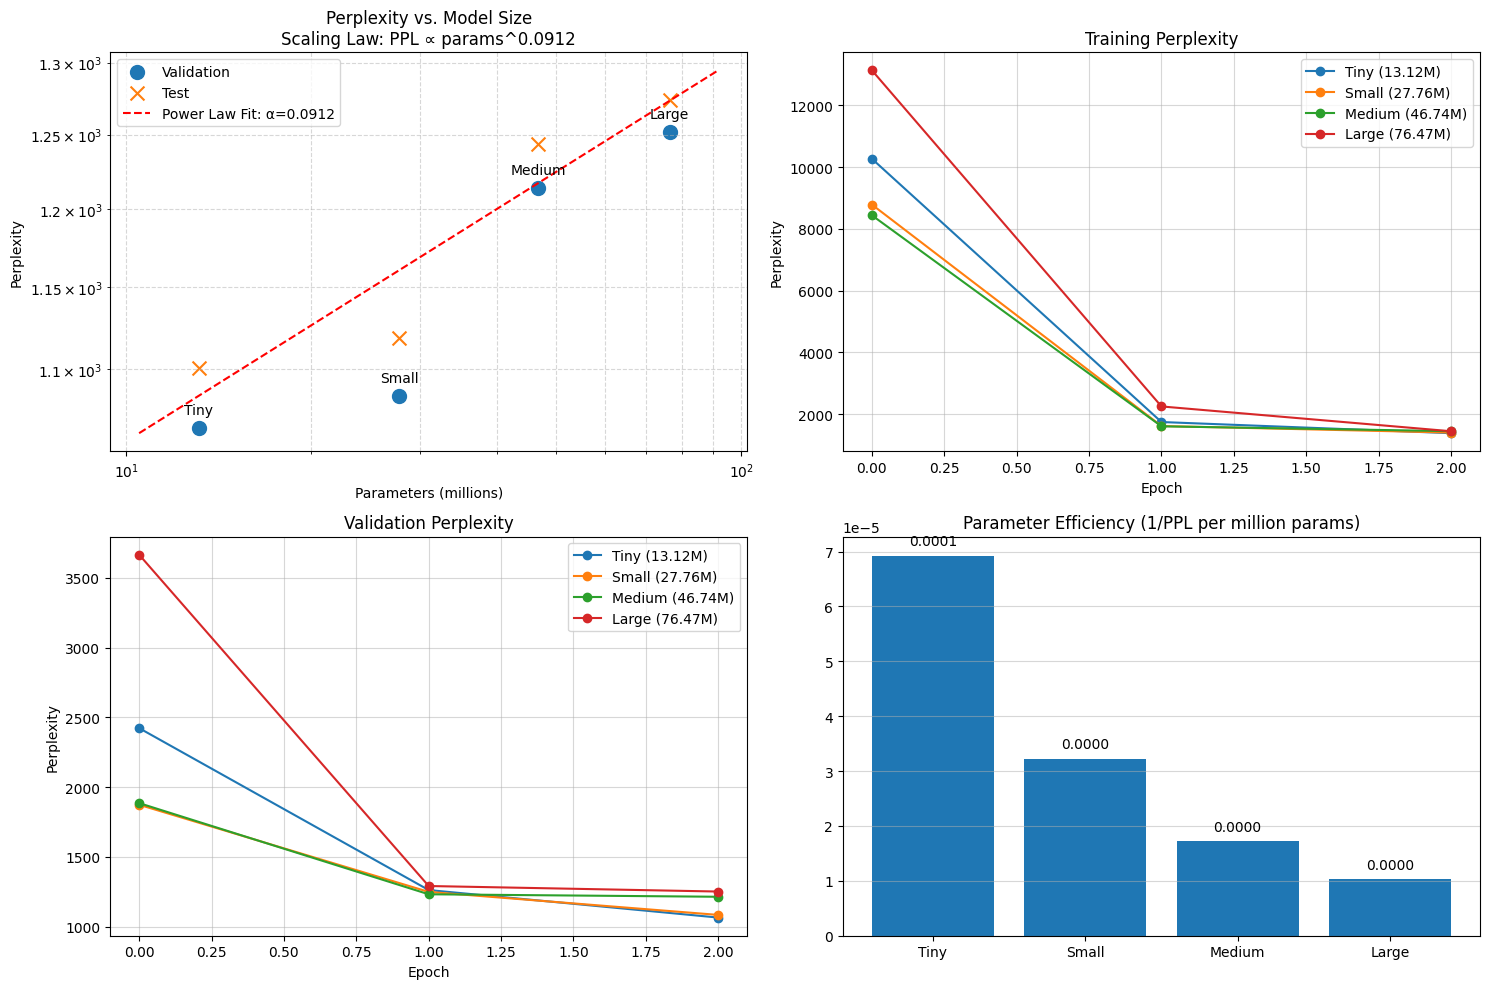

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import time
from tqdm import tqdm
from datasets import load_dataset
import json

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#----------------------------------------
# 1. Decoder-Only Transformer Model
#----------------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # Register as buffer (not a parameter but should be saved and moved with the model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Self-attention mechanism
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention block with residual connection and layer norm
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Feed-forward block with residual connection and layer norm
        ff_output = self.ffn(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super(TransformerLanguageModel, self).__init__()

        # Model dimensions
        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embeddings and positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Stack of decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Final layer norm
        self.final_norm = nn.LayerNorm(d_model)

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        # Generate mask if not provided (causal attention mask)
        if mask is None:
            mask = self._generate_square_subsequent_mask(x.size(1)).to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        # Convert to sequence-first format
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask=mask)

        # Final layer norm
        x = self.final_norm(x)

        # Convert back to batch-first format
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)

        # Project to vocabulary size
        logits = self.output_projection(x)

        return logits

    def _generate_square_subsequent_mask(self, sz):
        """Generate a causal mask for the decoder's self-attention."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def generate(self, start_tokens, max_length, temperature=1.0):
        """Generate text tokens autoregressively."""
        self.eval()
        with torch.no_grad():
            # Start with the initial tokens
            input_seq = start_tokens.to(device)

            for _ in range(max_length):
                # Create a causal mask
                mask = self._generate_square_subsequent_mask(input_seq.size(1)).to(device)

                # Forward pass
                logits = self(input_seq, mask)

                # Get the next token probabilities (last position)
                next_token_logits = logits[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)

                # Sample from the distribution
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # Append to the sequence
                input_seq = torch.cat([input_seq, next_token], dim=1)

            return input_seq

#----------------------------------------
# 2. WikiText-103 Dataset from HuggingFace
#----------------------------------------

class WikiTextDataset(Dataset):
    def __init__(self, texts, seq_length, tokenizer):
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        # Tokenize all texts and concatenate
        all_tokens = []
        for text in tqdm(texts, desc="Tokenizing texts"):
            if text.strip():  # Skip empty lines
                tokens = tokenizer.encode(text)
                all_tokens.extend(tokens)

        self.tokens = all_tokens

    def __len__(self):
        # Number of possible sequences (minus 1 for the target shift)
        return max(0, len(self.tokens) - self.seq_length - 1)

    def __getitem__(self, idx):
        # Get input sequence
        input_seq = self.tokens[idx:idx + self.seq_length]

        # Get target sequence (shifted by 1)
        target_seq = self.tokens[idx + 1:idx + self.seq_length + 1]

        return torch.tensor(input_seq), torch.tensor(target_seq)

class Tokenizer:
    def __init__(self, vocab_size=50000):
        self.vocab_size = vocab_size
        self.word_to_idx = {"<unk>": 0, "<pad>": 1, "<eos>": 2}
        self.idx_to_word = {0: "<unk>", 1: "<pad>", 2: "<eos>"}
        self.word_counts = {}
        self.vocab_built = False

    def build_vocab(self, texts):
        """Build vocabulary from a list of texts."""
        print("Building vocabulary...")
        # Count words across all texts
        for text in tqdm(texts, desc="Counting words"):
            if text.strip():  # Skip empty lines
                words = text.split()
                for word in words:
                    if word in self.word_counts:
                        self.word_counts[word] += 1
                    else:
                        self.word_counts[word] = 1

        # Sort by frequency
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)

        # Add top words to vocab (up to vocab_size)
        for i, (word, _) in enumerate(sorted_words[:self.vocab_size-3]):  # -3 for <unk>, <pad>, <eos>
            self.word_to_idx[word] = i + 3
            self.idx_to_word[i + 3] = word

        self.vocab_built = True
        actual_vocab_size = len(self.word_to_idx)
        print(f"Vocabulary built with {actual_vocab_size} tokens")
        return actual_vocab_size

    def encode(self, text):
        """Convert text to token indices."""
        if not self.vocab_built:
            raise ValueError("Vocabulary not built. Call build_vocab first.")

        words = text.split()
        return [self.word_to_idx.get(word, 0) for word in words]  # 0 is <unk>

    def decode(self, indices):
        """Convert token indices to text."""
        return " ".join([self.idx_to_word.get(idx, "<unk>") for idx in indices])

def load_wikitext103_from_huggingface(subset_size=1.0):
    """Load the WikiText-103 dataset from HuggingFace datasets."""
    print("Loading WikiText-103 dataset from HuggingFace...")

    # Load the dataset
    dataset = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")

    # Extract the texts
    train_texts = dataset['train']['text']
    validation_texts = dataset['validation']['text']
    test_texts = dataset['test']['text']

    # Filter out empty strings
    train_texts = [text for text in train_texts if text.strip()]
    validation_texts = [text for text in validation_texts if text.strip()]
    test_texts = [text for text in test_texts if text.strip()]

    # Take subset if specified
    if subset_size < 1.0:
        print(f"Using {subset_size*100:.1f}% of the dataset for faster training")
        train_size = int(len(train_texts) * subset_size)
        val_size = int(len(validation_texts) * subset_size)
        test_size = int(len(test_texts) * subset_size)

        train_texts = train_texts[:train_size]
        validation_texts = validation_texts[:val_size]
        test_texts = test_texts[:test_size]

    print(f"Dataset loaded. Train: {len(train_texts)} examples, "
          f"Validation: {len(validation_texts)} examples, "
          f"Test: {len(test_texts)} examples")

    return train_texts, validation_texts, test_texts

def create_dataloaders(train_texts, validation_texts, test_texts, seq_length, batch_size, vocab_size=50000):
    """Create dataloaders for training and evaluation."""
    # Create a tokenizer and build vocabulary
    tokenizer = Tokenizer(vocab_size)
    actual_vocab_size = tokenizer.build_vocab(train_texts)

    # Create datasets
    print("Creating datasets...")
    train_dataset = WikiTextDataset(train_texts, seq_length, tokenizer)
    validation_dataset = WikiTextDataset(validation_texts, seq_length, tokenizer)
    test_dataset = WikiTextDataset(test_texts, seq_length, tokenizer)

    print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(validation_dataset)}, Test: {len(test_dataset)}")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader, tokenizer, actual_vocab_size

#----------------------------------------
# 3. Training and Evaluation
#----------------------------------------

def train_epoch(model, dataloader, optimizer, criterion, clip_value=1.0, max_batches=None):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    total_tokens = 0

    pbar = tqdm(enumerate(dataloader), total=min(len(dataloader), max_batches or float('inf')),
               desc="Training")

    for batch_idx, (inputs, targets) in pbar:
        if max_batches and batch_idx >= max_batches:
            break

        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass - calculate causal mask
        mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
        outputs = model(inputs, mask)

        # Reshape outputs and targets for loss calculation
        outputs = outputs.reshape(-1, outputs.shape[-1])
        targets = targets.reshape(-1)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # Update parameters
        optimizer.step()

        # Accumulate loss and token count
        total_loss += loss.item() * targets.size(0)
        total_tokens += targets.size(0)

        # Update progress bar
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Return average loss
    return total_loss / total_tokens if total_tokens > 0 else float('inf')

def evaluate(model, dataloader, criterion, max_batches=None):
    """Evaluate the model on the validation or test set."""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc="Evaluating")):
            if max_batches and batch_idx >= max_batches:
                break

            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass - calculate causal mask
            mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
            outputs = model(inputs, mask)

            # Reshape outputs and targets for loss calculation
            outputs = outputs.reshape(-1, outputs.shape[-1])
            targets = targets.reshape(-1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss and token count
            total_loss += loss.item() * targets.size(0)
            total_tokens += targets.size(0)

    # Return average loss and perplexity
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

def train_model(config, train_loader, validation_loader, num_epochs=3, max_batches_per_epoch=None):
    """Train a single model configuration and track its performance."""
    print(f"\n{'='*50}")
    print(f"Training model: {config['name']}")
    print(f"{'='*50}")

    # Create model
    model = TransformerLanguageModel(
        vocab_size=config['vocab_size'],
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_layers'],
        dim_feedforward=config['dim_feedforward'],
        dropout=config['dropout']
    ).to(device)

    # Print model statistics
    num_params = model.count_parameters()
    print(f"Number of parameters: {num_params:,}")

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # Ignore padding token (1)

    # Track history
    history = {
        'name': config['name'],
        'num_params': num_params,
        'train_loss': [],
        'train_ppl': [],
        'val_loss': [],
        'val_ppl': []
    }

    # Training loop
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train for one epoch
        train_loss = train_epoch(model, train_loader, optimizer, criterion,
                                max_batches=max_batches_per_epoch)
        train_ppl = math.exp(train_loss)

        # Evaluate on validation set
        val_loss, val_ppl = evaluate(model, validation_loader, criterion, max_batches=max_batches_per_epoch)

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train PPL: {train_ppl:.2f}")
        print(f"Val Loss: {val_loss:.4f}, Val PPL: {val_ppl:.2f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_ppl'].append(train_ppl)
        history['val_loss'].append(val_loss)
        history['val_ppl'].append(val_ppl)

    # Calculate training time
    training_time = time.time() - start_time
    history['training_time'] = training_time
    print(f"Training completed in {training_time:.2f} seconds")

    return model, history

def scaling_experiment(configurations, train_loader, validation_loader, test_loader,
                      num_epochs=3, max_batches_per_epoch=None):
    """Run a scaling experiment with multiple model sizes."""
    models = []
    histories = []

    for config in configurations:
        model, history = train_model(config, train_loader, validation_loader,
                                    num_epochs, max_batches_per_epoch)
        models.append(model)
        histories.append(history)

        # Test the model immediately after training
        criterion = nn.CrossEntropyLoss(ignore_index=1)
        test_loss, test_ppl = evaluate(model, test_loader, criterion)
        print(f"Test Perplexity: {test_ppl:.2f}")

        # Save test results in history
        history['test_loss'] = test_loss
        history['test_ppl'] = test_ppl

    return models, histories

def plot_scaling_results(histories):
    """Plot the parameter scaling results."""
    plt.figure(figsize=(15, 10))

    # Extract data for plotting
    param_counts = [h['num_params'] / 1_000_000 for h in histories]  # Convert to millions
    final_val_ppl = [h['val_ppl'][-1] for h in histories]
    test_ppl = [h['test_ppl'] for h in histories]
    model_names = [h['name'] for h in histories]

    # Plot 1: Parameter count vs. validation perplexity (log-log plot)
    plt.subplot(2, 2, 1)
    plt.scatter(param_counts, final_val_ppl, s=100, label='Validation')
    plt.scatter(param_counts, test_ppl, s=100, marker='x', label='Test')

    # Add model names as annotations
    for i, name in enumerate(model_names):
        plt.annotate(name, (param_counts[i], final_val_ppl[i]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    # Add power law fit
    if len(param_counts) > 1:
        # Convert to log scale for fitting
        log_params = np.log(param_counts)
        log_ppl = np.log(test_ppl)

        # Linear regression
        coef = np.polyfit(log_params, log_ppl, 1)
        poly1d_fn = np.poly1d(coef)

        # Plot the fit line
        x_fit = np.linspace(min(param_counts) * 0.8, max(param_counts) * 1.2, 100)
        log_x_fit = np.log(x_fit)
        y_fit = np.exp(poly1d_fn(log_x_fit))

        plt.plot(x_fit, y_fit, '--r', label=f'Power Law Fit: α={coef[0]:.4f}')

        # Add the scaling law to the plot
        plt.title(f'Perplexity vs. Model Size\nScaling Law: PPL ∝ params^{coef[0]:.4f}')
    else:
        plt.title('Perplexity vs. Model Size')

    plt.xlabel('Parameters (millions)')
    plt.ylabel('Perplexity')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend()

    # Plot 2: Training curves
    plt.subplot(2, 2, 2)
    for history in histories:
        plt.plot(history['train_ppl'], marker='o',
                label=f"{history['name']} ({history['num_params']/1_000_000:.2f}M)")

    plt.title('Training Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Plot 3: Validation curves
    plt.subplot(2, 2, 3)
    for history in histories:
        plt.plot(history['val_ppl'], marker='o',
                label=f"{history['name']} ({history['num_params']/1_000_000:.2f}M)")

    plt.title('Validation Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Plot 4: Parameter efficiency
    plt.subplot(2, 2, 4)
    efficiency = [(1/ppl)/(count) for ppl, count in zip(test_ppl, param_counts)]

    bars = plt.bar(model_names, efficiency)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02 * max(efficiency),
                f'{height:.4f}', ha='center', va='bottom')

    plt.title('Parameter Efficiency (1/PPL per million params)')
    plt.grid(True, axis='y', alpha=0.5)

    plt.tight_layout()
    return plt.gcf()

#----------------------------------------
# 4. Main Execution
#----------------------------------------

def main():
    # Set hyperparameters
    seq_length = 64
    batch_size = 32
    num_epochs = 3
    vocab_size = 50000

    # Load the WikiText-103 dataset from HuggingFace
    train_texts, validation_texts, test_texts = load_wikitext103_from_huggingface(subset_size=0.05)

    # Create dataloaders
    train_loader, validation_loader, test_loader, tokenizer, actual_vocab_size = create_dataloaders(
        train_texts, validation_texts, test_texts, seq_length, batch_size, vocab_size
    )

    # Define model configurations with increasing parameter sizes
    configurations = [
        {
            'name': 'Tiny',
            'vocab_size': actual_vocab_size,
            'd_model': 128,
            'nhead': 2,
            'num_layers': 2,
            'dim_feedforward': 256,
            'dropout': 0.1,
            'learning_rate': 5e-4
        },
        {
            'name': 'Small',
            'vocab_size': actual_vocab_size,
            'd_model': 256,
            'nhead': 4,
            'num_layers': 4,
            'dim_feedforward': 512,
            'dropout': 0.1,
            'learning_rate': 3e-4
        },
        {
            'name': 'Medium',
            'vocab_size': actual_vocab_size,
            'd_model': 384,
            'nhead': 6,
            'num_layers': 6,
            'dim_feedforward': 1024,
            'dropout': 0.1,
            'learning_rate': 2e-4
        },
        {
            'name': 'Large',
            'vocab_size': actual_vocab_size,
            'd_model': 512,
            'nhead': 8,
            'num_layers': 8,
            'dim_feedforward': 2048,
            'dropout': 0.1,
            'learning_rate': 1e-4
        }
    ]

    # For faster experimentation, limit batches per epoch (remove or set to None for full training)
    max_batches_per_epoch = 50

    # Run the scaling experiment
    print("Starting scaling experiment...")
    models, histories = scaling_experiment(
        configurations, train_loader, validation_loader, test_loader,
        num_epochs=num_epochs, max_batches_per_epoch=max_batches_per_epoch
    )

    # Plot and save results
    print("Plotting scaling results...")
    fig = plot_scaling_results(histories)
    fig.savefig('transformer_scaling_laws.png')
    print("Plot saved as transformer_scaling_laws.png")

    # Print scaling law summary
    param_counts = np.array([h['num_params'] for h in histories])
    test_ppls = np.array([h['test_ppl'] for h in histories])

    log_params = np.log(param_counts)
    log_ppl = np.log(test_ppls)

    coef = np.polyfit(log_params, log_ppl, 1)
    scaling_exponent = coef[0]

    print("\nEmpirical Scaling Law:")
    print(f"Perplexity ∝ (parameters)^{scaling_exponent:.4f}")

    # Create parameter scaling table
    print("\nParameter Scaling Results:")
    print("=" * 80)
    print(f"{'Model':<8} | {'Params':<10} | {'Test PPL':<10} | {'Relative PPL':<15} | {'Param Efficiency':<15}")
    print("-" * 80)

    base_ppl = None

    for i, history in enumerate(histories):
        params_m = history['num_params'] / 1_000_000  # Convert to millions
        test_ppl = history['test_ppl']

        if i == 0:
            base_ppl = test_ppl
            rel_ppl = 1.0
        else:
            rel_ppl = test_ppl / base_ppl

        efficiency = (1 / test_ppl) / params_m

        print(f"{history['name']:<8} | {params_m:.4f}M    | {test_ppl:.2f}      | {rel_ppl:.4f}         | {efficiency:.6f}")

    # Save historical data to file for future reference
    with open('scaling_experiment_results.json', 'w') as f:
        # Convert numpy types to Python native types for JSON serialization
        serializable_histories = []
        for h in histories:
            serializable_h = {}
            for k, v in h.items():
                if isinstance(v, (np.ndarray, np.number)):
                    serializable_h[k] = v.item() if isinstance(v, np.number) else v.tolist()
                else:
                    serializable_h[k] = v
            serializable_histories.append(serializable_h)

        json.dump(serializable_histories, f, indent=2)

    print("\nExperiment results saved to scaling_experiment_results.json")

    # Generate sample texts with each model
    print("\nGenerating sample texts from each model...")
    sample_prompts = [
        "the president of the united states",
        "researchers discovered that the new",
        "the history of artificial intelligence"
    ]

    for i, model in enumerate(models):
        print(f"\n{configurations[i]['name']} Model ({histories[i]['num_params']/1_000_000:.2f}M parameters):")
        for prompt in sample_prompts:
            # Tokenize prompt
            prompt_tokens = torch.tensor([tokenizer.encode(prompt)]).to(device)

            # Generate text
            generated_tokens = model.generate(prompt_tokens, max_length=30, temperature=0.8)
            generated_text = tokenizer.decode(generated_tokens[0].cpu().numpy())

            print(f"  Prompt: '{prompt}'")
            print(f"  Generated: '{generated_text}'")
            print()

    print("\nScaling experiment completed!")

    return models, histories, tokenizer

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import time
from tqdm import tqdm
from datasets import load_dataset
import json

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#----------------------------------------
# 1. Decoder-Only Transformer Model
#----------------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # Register as buffer (not a parameter but should be saved and moved with the model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Self-attention mechanism
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention block with residual connection and layer norm
        attn_output, _ = self.self_attn(x, x, x, attn_mask=mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)

        # Feed-forward block with residual connection and layer norm
        ff_output = self.ffn(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)

        return x

class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6,
                 dim_feedforward=2048, dropout=0.1):
        super(TransformerLanguageModel, self).__init__()

        # Model dimensions
        self.d_model = d_model
        self.vocab_size = vocab_size

        # Embeddings and positional encoding
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Stack of decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Final layer norm
        self.final_norm = nn.LayerNorm(d_model)

        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

        # Initialize parameters
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        # Generate mask if not provided (causal attention mask)
        if mask is None:
            mask = self._generate_square_subsequent_mask(x.size(1)).to(x.device)

        # Embedding and positional encoding
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        # Convert to sequence-first format
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)

        # Pass through decoder layers
        for layer in self.layers:
            x = layer(x, mask=mask)

        # Final layer norm
        x = self.final_norm(x)

        # Convert back to batch-first format
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)

        # Project to vocabulary size
        logits = self.output_projection(x)

        return logits

    def _generate_square_subsequent_mask(self, sz):
        """Generate a causal mask for the decoder's self-attention."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def count_parameters(self):
        """Count the number of trainable parameters in the model."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def generate(self, start_tokens, max_length, temperature=1.0):
        """Generate text tokens autoregressively."""
        self.eval()
        with torch.no_grad():
            # Start with the initial tokens
            input_seq = start_tokens.to(device)

            for _ in range(max_length):
                # Create a causal mask
                mask = self._generate_square_subsequent_mask(input_seq.size(1)).to(device)

                # Forward pass
                logits = self(input_seq, mask)

                # Get the next token probabilities (last position)
                next_token_logits = logits[:, -1, :] / temperature
                next_token_probs = F.softmax(next_token_logits, dim=-1)

                # Sample from the distribution
                next_token = torch.multinomial(next_token_probs, num_samples=1)

                # Append to the sequence
                input_seq = torch.cat([input_seq, next_token], dim=1)

            return input_seq

#----------------------------------------
# 2. OpenWebText Dataset from HuggingFace
#----------------------------------------

class OpenWebTextDataset(Dataset):
    def __init__(self, texts, seq_length, tokenizer):
        self.tokenizer = tokenizer
        self.seq_length = seq_length

        # Tokenize all texts and concatenate
        all_tokens = []
        for text in tqdm(texts, desc="Tokenizing texts"):
            if text.strip():  # Skip empty lines
                tokens = tokenizer.encode(text)
                all_tokens.extend(tokens)

        self.tokens = all_tokens

    def __len__(self):
        # Number of possible sequences (minus 1 for the target shift)
        return max(0, len(self.tokens) - self.seq_length - 1)

    def __getitem__(self, idx):
        # Get input sequence
        input_seq = self.tokens[idx:idx + self.seq_length]

        # Get target sequence (shifted by 1)
        target_seq = self.tokens[idx + 1:idx + self.seq_length + 1]

        return torch.tensor(input_seq), torch.tensor(target_seq)

class Tokenizer:
    def __init__(self, vocab_size=50000):
        self.vocab_size = vocab_size
        self.word_to_idx = {"<unk>": 0, "<pad>": 1, "<eos>": 2}
        self.idx_to_word = {0: "<unk>", 1: "<pad>", 2: "<eos>"}
        self.word_counts = {}
        self.vocab_built = False

    def build_vocab(self, texts):
        """Build vocabulary from a list of texts."""
        print("Building vocabulary...")
        # Count words across all texts
        for text in tqdm(texts, desc="Counting words"):
            if text.strip():  # Skip empty lines
                words = text.split()
                for word in words:
                    if word in self.word_counts:
                        self.word_counts[word] += 1
                    else:
                        self.word_counts[word] = 1

        # Sort by frequency
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)

        # Add top words to vocab (up to vocab_size)
        for i, (word, _) in enumerate(sorted_words[:self.vocab_size-3]):  # -3 for <unk>, <pad>, <eos>
            self.word_to_idx[word] = i + 3
            self.idx_to_word[i + 3] = word

        self.vocab_built = True
        actual_vocab_size = len(self.word_to_idx)
        print(f"Vocabulary built with {actual_vocab_size} tokens")
        return actual_vocab_size

    def encode(self, text):
        """Convert text to token indices."""
        if not self.vocab_built:
            raise ValueError("Vocabulary not built. Call build_vocab first.")

        words = text.split()
        return [self.word_to_idx.get(word, 0) for word in words]  # 0 is <unk>

    def decode(self, indices):
        """Convert token indices to text."""
        return " ".join([self.idx_to_word.get(idx, "<unk>") for idx in indices])

def load_openwebtext_from_huggingface(subset_size=1.0):
    """Load the OpenWebText dataset from HuggingFace datasets."""
    print("Loading OpenWebText dataset from HuggingFace...")

    # Load the dataset
    # OpenWebText has only a 'train' split
    dataset = load_dataset("openwebtext")

    # Extract the texts
    # In OpenWebText, the text field is named 'text'
    train_texts = dataset['train']['text']

    # Since OpenWebText doesn't have validation/test sets, we'll create splits
    total_samples = len(train_texts)
    train_size = int(total_samples * 0.8)  # 80% train
    val_size = int(total_samples * 0.1)    # 10% validation

    # Split the data
    shuffled_indices = np.random.permutation(total_samples)
    train_indices = shuffled_indices[:train_size]
    val_indices = shuffled_indices[train_size:train_size+val_size]
    test_indices = shuffled_indices[train_size+val_size:]

    train_texts_split = [train_texts[i] for i in train_indices]
    validation_texts = [train_texts[i] for i in val_indices]
    test_texts = [train_texts[i] for i in test_indices]

    # Filter out empty strings
    train_texts_split = [text for text in train_texts_split if text.strip()]
    validation_texts = [text for text in validation_texts if text.strip()]
    test_texts = [text for text in test_texts if text.strip()]

    # Take subset if specified
    if subset_size < 1.0:
        print(f"Using {subset_size*100:.1f}% of the dataset for faster training")
        train_size = int(len(train_texts_split) * subset_size)
        val_size = int(len(validation_texts) * subset_size)
        test_size = int(len(test_texts) * subset_size)

        train_texts_split = train_texts_split[:train_size]
        validation_texts = validation_texts[:val_size]
        test_texts = test_texts[:test_size]

    print(f"Dataset loaded. Train: {len(train_texts_split)} examples, "
          f"Validation: {len(validation_texts)} examples, "
          f"Test: {len(test_texts)} examples")

    return train_texts_split, validation_texts, test_texts

def create_dataloaders(train_texts, validation_texts, test_texts, seq_length, batch_size, vocab_size=50000):
    """Create dataloaders for training and evaluation."""
    # Create a tokenizer and build vocabulary
    tokenizer = Tokenizer(vocab_size)
    actual_vocab_size = tokenizer.build_vocab(train_texts)

    # Create datasets
    print("Creating datasets...")
    train_dataset = OpenWebTextDataset(train_texts, seq_length, tokenizer)
    validation_dataset = OpenWebTextDataset(validation_texts, seq_length, tokenizer)
    test_dataset = OpenWebTextDataset(test_texts, seq_length, tokenizer)

    print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(validation_dataset)}, Test: {len(test_dataset)}")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader, tokenizer, actual_vocab_size

#----------------------------------------
# 3. Training and Evaluation
#----------------------------------------

def train_epoch(model, dataloader, optimizer, criterion, clip_value=1.0, max_batches=None):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    total_tokens = 0

    pbar = tqdm(enumerate(dataloader), total=min(len(dataloader), max_batches or float('inf')),
               desc="Training")

    for batch_idx, (inputs, targets) in pbar:
        if max_batches and batch_idx >= max_batches:
            break

        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass - calculate causal mask
        mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
        outputs = model(inputs, mask)

        # Reshape outputs and targets for loss calculation
        outputs = outputs.reshape(-1, outputs.shape[-1])
        targets = targets.reshape(-1)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # Update parameters
        optimizer.step()

        # Accumulate loss and token count
        total_loss += loss.item() * targets.size(0)
        total_tokens += targets.size(0)

        # Update progress bar
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Return average loss
    return total_loss / total_tokens if total_tokens > 0 else float('inf')

def evaluate(model, dataloader, criterion, max_batches=None):
    """Evaluate the model on the validation or test set."""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc="Evaluating")):
            if max_batches and batch_idx >= max_batches:
                break

            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass - calculate causal mask
            mask = model._generate_square_subsequent_mask(inputs.size(1)).to(device)
            outputs = model(inputs, mask)

            # Reshape outputs and targets for loss calculation
            outputs = outputs.reshape(-1, outputs.shape[-1])
            targets = targets.reshape(-1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss and token count
            total_loss += loss.item() * targets.size(0)
            total_tokens += targets.size(0)

    # Return average loss and perplexity
    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

def train_model(config, train_loader, validation_loader, num_epochs=3, max_batches_per_epoch=None):
    """Train a single model configuration and track its performance."""
    print(f"\n{'='*50}")
    print(f"Training model: {config['name']}")
    print(f"{'='*50}")

    # Create model
    model = TransformerLanguageModel(
        vocab_size=config['vocab_size'],
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_layers'],
        dim_feedforward=config['dim_feedforward'],
        dropout=config['dropout']
    ).to(device)

    # Print model statistics
    num_params = model.count_parameters()
    print(f"Number of parameters: {num_params:,}")

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # Ignore padding token (1)

    # Track history
    history = {
        'name': config['name'],
        'num_params': num_params,
        'train_loss': [],
        'train_ppl': [],
        'val_loss': [],
        'val_ppl': []
    }

    # Training loop
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train for one epoch
        train_loss = train_epoch(model, train_loader, optimizer, criterion,
                                max_batches=max_batches_per_epoch)
        train_ppl = math.exp(train_loss)

        # Evaluate on validation set
        val_loss, val_ppl = evaluate(model, validation_loader, criterion, max_batches=max_batches_per_epoch)

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train PPL: {train_ppl:.2f}")
        print(f"Val Loss: {val_loss:.4f}, Val PPL: {val_ppl:.2f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_ppl'].append(train_ppl)
        history['val_loss'].append(val_loss)
        history['val_ppl'].append(val_ppl)

    # Calculate training time
    training_time = time.time() - start_time
    history['training_time'] = training_time
    print(f"Training completed in {training_time:.2f} seconds")

    return model, history

def scaling_experiment(configurations, train_loader, validation_loader, test_loader,
                      num_epochs=3, max_batches_per_epoch=None):
    """Run a scaling experiment with multiple model sizes."""
    models = []
    histories = []

    for config in configurations:
        model, history = train_model(config, train_loader, validation_loader,
                                    num_epochs, max_batches_per_epoch)
        models.append(model)
        histories.append(history)

        # Test the model immediately after training
        criterion = nn.CrossEntropyLoss(ignore_index=1)
        test_loss, test_ppl = evaluate(model, test_loader, criterion)
        print(f"Test Perplexity: {test_ppl:.2f}")

        # Save test results in history
        history['test_loss'] = test_loss
        history['test_ppl'] = test_ppl

    return models, histories

def plot_scaling_results(histories):
    """Plot the parameter scaling results."""
    plt.figure(figsize=(15, 10))

    # Extract data for plotting
    param_counts = [h['num_params'] / 1_000_000 for h in histories]  # Convert to millions
    final_val_ppl = [h['val_ppl'][-1] for h in histories]
    test_ppl = [h['test_ppl'] for h in histories]
    model_names = [h['name'] for h in histories]

    # Plot 1: Parameter count vs. validation perplexity (log-log plot)
    plt.subplot(2, 2, 1)
    plt.scatter(param_counts, final_val_ppl, s=100, label='Validation')
    plt.scatter(param_counts, test_ppl, s=100, marker='x', label='Test')

    # Add model names as annotations
    for i, name in enumerate(model_names):
        plt.annotate(name, (param_counts[i], final_val_ppl[i]),
                    textcoords="offset points", xytext=(0,10), ha='center')

    # Add power law fit
    if len(param_counts) > 1:
        # Convert to log scale for fitting
        log_params = np.log(param_counts)
        log_ppl = np.log(test_ppl)

        # Linear regression
        coef = np.polyfit(log_params, log_ppl, 1)
        poly1d_fn = np.poly1d(coef)

        # Plot the fit line
        x_fit = np.linspace(min(param_counts) * 0.8, max(param_counts) * 1.2, 100)
        log_x_fit = np.log(x_fit)
        y_fit = np.exp(poly1d_fn(log_x_fit))

        plt.plot(x_fit, y_fit, '--r', label=f'Power Law Fit: α={coef[0]:.4f}')

        # Add the scaling law to the plot
        plt.title(f'Perplexity vs. Model Size\nScaling Law: PPL ∝ params^{coef[0]:.4f}')
    else:
        plt.title('Perplexity vs. Model Size')

    plt.xlabel('Parameters (millions)')
    plt.ylabel('Perplexity')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.legend()

    # Plot 2: Training curves
    plt.subplot(2, 2, 2)
    for history in histories:
        plt.plot(history['train_ppl'], marker='o',
                label=f"{history['name']} ({history['num_params']/1_000_000:.2f}M)")

    plt.title('Training Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Plot 3: Validation curves
    plt.subplot(2, 2, 3)
    for history in histories:
        plt.plot(history['val_ppl'], marker='o',
                label=f"{history['name']} ({history['num_params']/1_000_000:.2f}M)")

    plt.title('Validation Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.grid(True, alpha=0.5)

    # Plot 4: Parameter efficiency
    plt.subplot(2, 2, 4)
    efficiency = [(1/ppl)/(count) for ppl, count in zip(test_ppl, param_counts)]

    bars = plt.bar(model_names, efficiency)

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02 * max(efficiency),
                f'{height:.4f}', ha='center', va='bottom')

    plt.title('Parameter Efficiency (1/PPL per million params)')
    plt.grid(True, axis='y', alpha=0.5)

    plt.tight_layout()
    return plt.gcf()

#----------------------------------------
# 4. Main Execution
#----------------------------------------

def main():
    # Set hyperparameters
    seq_length = 64
    batch_size = 32
    num_epochs = 3
    vocab_size = 50000

    # Load the OpenWebText dataset from HuggingFace
    train_texts, validation_texts, test_texts = load_openwebtext_from_huggingface(subset_size=0.01)  # Using smaller subset for faster experiments

    # Create dataloaders
    train_loader, validation_loader, test_loader, tokenizer, actual_vocab_size = create_dataloaders(
        train_texts, validation_texts, test_texts, seq_length, batch_size, vocab_size
    )

    # Define model configurations with increasing parameter sizes
    configurations = [
        {
            'name': 'Tiny',
            'vocab_size': actual_vocab_size,
            'd_model': 128,
            'nhead': 2,
            'num_layers': 2,
            'dim_feedforward': 256,
            'dropout': 0.1,
            'learning_rate': 5e-4
        },
        {
            'name': 'Small',
            'vocab_size': actual_vocab_size,
            'd_model': 256,
            'nhead': 4,
            'num_layers': 4,
            'dim_feedforward': 512,
            'dropout': 0.1,
            'learning_rate': 3e-4
        },
        {
            'name': 'Medium',
            'vocab_size': actual_vocab_size,
            'd_model': 384,
            'nhead': 6,
            'num_layers': 6,
            'dim_feedforward': 1024,
            'dropout': 0.1,
            'learning_rate': 2e-4
        },
        {
            'name': 'Large',
            'vocab_size': actual_vocab_size,
            'd_model': 512,
            'nhead': 8,
            'num_layers': 8,
            'dim_feedforward': 2048,
            'dropout': 0.1,
            'learning_rate': 1e-4
        }
    ]

    # For faster experimentation, limit batches per epoch (remove or set to None for full training)
    max_batches_per_epoch = None

    # Run the scaling experiment
    print("Starting scaling experiment...")
    models, histories = scaling_experiment(
        configurations, train_loader, validation_loader, test_loader,
        num_epochs=num_epochs, max_batches_per_epoch=max_batches_per_epoch
    )

    # Plot and save results
    print("Plotting scaling results...")
    fig = plot_scaling_results(histories)
    fig.savefig('transformer_scaling_laws_openwebtext.png')
    print("Plot saved as transformer_scaling_laws_openwebtext.png")

    # Print scaling law summary
    param_counts = np.array([h['num_params'] for h in histories])
    test_ppls = np.array([h['test_ppl'] for h in histories])

    log_params = np.log(param_counts)
    log_ppl = np.log(test_ppls)

    coef = np.polyfit(log_params, log_ppl, 1)
    scaling_exponent = coef[0]

    print("\nEmpirical Scaling Law:")
    print(f"Perplexity ∝ (parameters)^{scaling_exponent:.4f}")

    # Create parameter scaling table
    print("\nParameter Scaling Results:")
    print("=" * 80)
    print(f"{'Model':<8} | {'Params':<10} | {'Test PPL':<10} | {'Relative PPL':<15} | {'Param Efficiency':<15}")
    print("-" * 80)

    base_ppl = None

    for i, history in enumerate(histories):
        params_m = history['num_params'] / 1_000_000  # Convert to millions
        test_ppl = history['test_ppl']

        if i == 0:
            base_ppl = test_ppl
            rel_ppl = 1.0
        else:
            rel_ppl = test_ppl / base_ppl

        efficiency = (1 / test_ppl) / params_m

        print(f"{history['name']:<8} | {params_m:.4f}M    | {test_ppl:.2f}      | {rel_ppl:.4f}         | {efficiency:.6f}")

    # Save historical data to file for future reference
    with open('scaling_experiment_results_openwebtext.json', 'w') as f:
        # Convert numpy types to Python native types for JSON serialization
        serializable_histories = []
        for h in histories:
            serializable_h = {}
            for k, v in h.items():
                if isinstance(v, (np.ndarray, np.number)):
                    serializable_h[k] = v.item() if isinstance(v, np.number) else v.tolist()
                else:
                    serializable_h[k] = v
            serializable_histories.append(serializable_h)

        json.dump(serializable_histories, f, indent=2)

    print("\nExperiment results saved to scaling_experiment_results_openwebtext.json")

    # Generate sample texts with each model
    print("\nGenerating sample texts from each model...")
    sample_prompts = [
        "the president of the united states",
        "researchers discovered that the new",
        "the history of artificial intelligence"
    ]

    for i, model in enumerate(models):
        print(f"\n{configurations[i]['name']} Model ({histories[i]['num_params']/1_000_000:.2f}M parameters):")
        for prompt in sample_prompts:
            # Tokenize prompt
            prompt_tokens = torch.tensor([tokenizer.encode(prompt)]).to(device)

            # Generate text
            generated_tokens = model.generate(prompt_tokens, max_length=30, temperature=0.8)
            generated_text = tokenizer.decode(generated_tokens[0].cpu().numpy())

            print(f"  Prompt: '{prompt}'")
            print(f"  Generated: '{generated_text}'")
            print()

    print("\nScaling experiment completed!")

    return models, histories, tokenizer

if __name__ == "__main__":
    main()